In [1]:
!pip install --upgrade pip
!pip install python-decouple
!pip install geoalchemy2
!pip install shapely
!pip install scipy
!pip install hyperas

    100% |████████████████████████████████| 1.4MB 24.4MB/s eta 0:00:01
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1
  Stored in directory: /home/ec2-user/.cache/pip/wheels/0f/ee/80/75b684060dc6ecc5a28c07b75ef4063f378aff1a37556f342a
Successfully built python-decouple
     |████████████████████████████████| 1.5MB 1.7MB/s eta 0:00:01
     |████████████████████████████████| 122kB 2.4MB/s eta 0:00:01
     |████████████████████████████████| 419kB 4.5MB/s eta 0:00:01
     |████████████████████████████████| 829kB 5.7MB/s eta 0:00:01
     |████████████████████████████████| 51kB 12.2MB/s eta 0:00:01


  Stored in directory: /home/ec2-user/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built future


In [2]:
from sqlalchemy import create_engine, func, text
from sqlalchemy.orm import sessionmaker
from decouple import config
from shapely import wkb, wkt
from shapely.geometry import Point
from geoalchemy2.shape import to_shape 

import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
import re
from matplotlib import pyplot as plt
import random

from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV

from hyperas.distributions import uniform



# ----------- TODO: Issues with importing imbalance-learn library
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import NearMiss
# from imblearn.under_sampling import (RandomUnderSampler,
#                                      ClusterCentroids,
#                                      TomekLinks,
#                                      NeighbourhoodCleaningRule,
#                                      NearMiss)

Using TensorFlow backend.


In [3]:
"""Contains models for DB."""

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, BigInteger, Integer, String, DateTime, ForeignKey, Float
from sqlalchemy.orm import relationship
from geoalchemy2 import Geometry


BASE = declarative_base()


class City(BASE):
    """City model for DB. Has information of cities."""
    __tablename__ = 'city'
    id            = Column(BigInteger, primary_key=True)
    city          = Column(String, unique=False, nullable=False)
    state         = Column(String, unique=False, nullable=True)
    country       = Column(String, unique=False, nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    blocks        = relationship("Blocks", back_populates="city")
    zipcodes      = relationship("ZipcodeGeom", back_populates="city")
    incidents     = relationship("Incident", back_populates="city")


class Blocks(BASE):
    """Block model for DB. Has information of city blocks for a related city
        id."""
    __tablename__ = 'block'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    population    = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="blocks")
    incidents     = relationship("Incident", back_populates="block")

class ZipcodeGeom(BASE):
    """Zipcode geometry model for DB. Has information of zipcodes and related
        city id."""
    __tablename__ = 'zipcodegeom'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    zipcode       = Column(String, nullable=False, unique=True)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    city          = relationship("City", back_populates="zipcodes")

class Incident(BASE):
    """Incident model for DB. Has information of a specific crime, including
        where it took place, when it took place, and the type of crime that
        occurred."""
    __tablename__ = 'incident'
    id            = Column(BigInteger, primary_key=True)
    crimetypeid   = Column(BigInteger, ForeignKey('crimetype.id'), nullable=False)
    locdescid     = Column(BigInteger, ForeignKey('locdesctype.id'), nullable=False)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    blockid       = Column(BigInteger, ForeignKey('block.id'), nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    datetime      = Column(DateTime, nullable=False)
    hour          = Column(Integer, nullable=False)
    dow           = Column(Integer, nullable=False)
    month         = Column(Integer, nullable=False)
    year          = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="incidents")
    block         = relationship("Blocks", back_populates="incidents")
    crimetype     = relationship("CrimeType", back_populates="incidents")
    locationdesc  = relationship("LocationDescriptionType", back_populates="incidents")

class CrimeType(BASE):
    """CrimeType model for DB. Has information of the types of crime, including
        a general description and the numerical severity of the crime."""
    __tablename__ = 'crimetype'
    id            = Column(BigInteger, primary_key=True)
    category      = Column(String, unique=True, nullable=False)
    severity      = Column(Integer, nullable=False)
    incidents     = relationship("Incident", back_populates="crimetype")


class LocationDescriptionType(BASE):
    """Location description model for DB. Has information on the type of
        location that the crime took place."""
    __tablename__ = 'locdesctype'
    id            = Column(BigInteger, primary_key=True)
    key1          = Column(String, nullable=False)
    key2          = Column(String, nullable=False)
    key3          = Column(String, nullable=False)
    incidents     = relationship("Incident", back_populates="locationdesc")

In [4]:
use_counts = True  # Use crime counts instead of severity ratings
do_gridsearch = True

if use_counts == True:
    SEVERITY_SCALING_FACTOR = 1000.
    SEVERITY_OPERATOR = '*'
else:
    SEVERITY_SCALING_FACTOR = 1000.
    SEVERITY_OPERATOR = '*'

def scale_data(X):
    if use_counts == True:
        X *= SEVERITY_SCALING_FACTOR  # This we will use with the count(severity) SQL query
    else:
        X *= SEVERITY_SCALING_FACTOR  # This gave us good results earlier with the 
                                      # severity/avg(population) SQL query
    return X

def descale_data(X):
    if use_counts == True:
        X /= SEVERITY_SCALING_FACTOR  # This we will use with the count(severity) SQL query
    else:
        X /= SEVERITY_SCALING_FACTOR  # This gave us good results earlier with the 
                                      # severity/avg(population) SQL query
    return X

class GetData(object):
    def go(self, SESSION, start_year, end_year):
        if use_counts == True:
            SQL_QUERY = \
                f'''
                    SELECT
                        incident.blockid,
                        incident.datetime,
                        incident.year,
                        incident.month,
                        incident.dow,
                        incident.hour,
                        COUNT(crimetype.severity)/AVG(block.population)*1000.0::DECIMAL AS severity
                    FROM incident
                    INNER JOIN block ON incident.blockid = block.id
                    INNER JOIN crimetype ON incident.crimetypeid = crimetype.id
                        AND block.population > 0
                        AND incident.cityid = 1
                        AND incident.year >= {start_year}
                        AND incident.year <= {end_year}
                    GROUP BY
                        incident.blockid,
                        incident.datetime,
                        incident.year,
                        incident.month,
                        incident.dow,
                        incident.hour
                '''
        else:
            SQL_QUERY = \
                f'''
                    WITH
                        max_severity AS (
                            SELECT MAX(severity) AS severity
                            FROM (
                                SELECT SUM(crimetype.severity)/AVG(block.population) AS severity
                                FROM incident
                                INNER JOIN block ON incident.blockid = block.id INNER JOIN crimetype ON incident.crimetypeid = crimetype.id AND block.population > 0
                                GROUP BY
                                    incident.blockid,
                                    incident.year,
                                    incident.month,
                                    incident.dow
                            ) AS categories
                        ),
                        block_incidents AS (
                            SELECT
                                incident.blockid,
                                incident.datetime,
                                incident.year,
                                incident.month,
                                incident.dow,
                                SUM(crimetype.severity)/AVG(block.population) AS severity
                            FROM incident
                            INNER JOIN block ON incident.blockid = block.id
                            INNER JOIN crimetype ON incident.crimetypeid = crimetype.id
                                AND block.population > 0
                                AND incident.cityid = 1
                                AND incident.year >= {start_year}
                                AND incident.year <= {end_year}
                            GROUP BY
                                incident.blockid,
                                incident.datetime,
                                incident.year,
                                incident.month,
                                incident.dow
                        )
                    SELECT
                        block_incidents.blockid,
                        block_incidents.datetime,
                        block_incidents.year,
                        block_incidents.month,
                        block_incidents.dow,
                        block_incidents.severity/max_severity.severity AS severity
                    FROM block_incidents, max_severity        
                '''
        return SESSION.execute(text(SQL_QUERY)).fetchall()

In [5]:
DAY_OF_WEEK  = 0
DAY_OF_MONTH = 1
HOUR_OF_DAY  = 2

def fill_data(X, y, r, start_year, end_year, blockid_dict, data_type):
    
    def day_of_month(x):
        return x.day - 1

    def hour_of_day(x):
        return x.hour
    
    if r[2] == end_year:
        if data_type == DAY_OF_WEEK:
            #                     block id       0-based month
            #                vvvvvvvvvvvvvvvvv   vvvvvv
            y[blockid_dict[r[0]], r[3]-1, r[4]] = float(r[5])
            #                                            ^^^^        ^^^^
            #                                            dow         risk
        elif data_type == DAY_OF_MONTH:
            #                     block id       0-based month
            #                vvvvvvvvvvvvvvvvv   vvvvvv
            y[blockid_dict[r[0]], r[3]-1, day_of_month(r[1])] = float(r[5])
            #                                            ^^^^^^^^^^^^^^^^^^        ^^^^
            #                                                  dom                 risk
        elif data_type == HOUR_OF_DAY:
            #                     block id       0-based month
            #                vvvvvvvvvvvvvvvvv   vvvvvv
            y[blockid_dict[r[0]], r[3]-1, hour_of_day(r[1])] = float(r[5])
            #                                             ^^^^^^^^^^^^^^^         ^^^^
            #                                               hour of day           risk
        else:
            raise ValueError('Unsupported data type:', data_type)
    else:
        if data_type == DAY_OF_WEEK:
            X[blockid_dict[r[0]], 12*(r[2]-start_year-1)+r[3]-1, r[4]] = float(r[5])
        elif data_type == DAY_OF_MONTH:
            X[blockid_dict[r[0]], 12*(r[2]-start_year-1)+r[3]-1, day_of_month(r[1])] = float(r[5])
        elif data_type == HOUR_OF_DAY:
            X[blockid_dict[r[0]], 12*(r[2]-start_year-1)+r[3]-1, hour_of_day(r[1])] = float(r[5])
        else:
            raise ValueError('Unsupported data type:', data_type)

In [6]:
def process_data(data, start_year, end_year, blockid_dict, data_type):

    if data_type == DAY_OF_WEEK:
        X = np.zeros((len(blockid_dict), 24, 7))
        y = np.zeros((len(blockid_dict), 12, 7))
    elif data_type == DAY_OF_MONTH:
        X = np.zeros((len(blockid_dict), 24, 31))
        y = np.zeros((len(blockid_dict), 12, 31))
    elif data_type == HOUR_OF_DAY:
        X = np.zeros((len(blockid_dict), 24, 24))
        y = np.zeros((len(blockid_dict), 12, 24))
    
    # records is the list of rows we get from the query with this order:
    #   blockid, year, month, dow, hour, risk
    #   month is from 1 - 12

    for r in data:
        if r[0] in blockid_dict:
            fill_data(X, y, r, start_year, end_year, blockid_dict, data_type)

    X = scale_data(X)
    y = scale_data(y)

    #     for i in range(24):
    #         X[:, i, -1] = (start_year*12+i) / (2000 * 12)
        
    return X, y

In [7]:
from contextlib import contextmanager

@contextmanager
def session_scope():
    """Provide a transactional scope around a series of operations."""

    DB_URI  = config('DB_URI')
    ENGINE  = create_engine(DB_URI)
    Session = sessionmaker(bind=ENGINE)
    SESSION = Session()
    
    try:
        yield SESSION
        SESSION.commit()
    except:
        SESSION.rollback()
        raise
    finally:
        SESSION.close()


def ready_data(training_start_year, training_end_year, train_blockid_dict,
               testing_start_year, testing_end_year, test_blockid_dict,
               data_type):
    with session_scope() as session:
        training_data = GetData().go(session,
                                     training_start_year,
                                     training_end_year)
        testing_data = GetData().go(session,
                                     testing_start_year,
                                     testing_end_year)
        
        X_train, y_train = process_data(training_data,
                                        training_start_year, 
                                        training_end_year,
                                        train_blockid_dict,
                                        data_type)
        X_test, y_test = process_data(testing_data,
                                      testing_start_year, 
                                      testing_end_year,
                                      test_blockid_dict,
                                      data_type)

    return X_train, X_test, y_train, y_test

## Day of week analysis for each month of each block id

In [8]:
# start month = 3, end_month = 2 (months are 0-indexed)
#   X: 4/2017 -> 3/2019 actual date
#   y: 4/2019 -> 3/2020 actual date
#
X_test_start_month = 0
X_test_end_month   = 0
X_test_start_year  = 2016
X_test_end_year    = 2018

TRAIN_NUM_BLOCKIDS = TEST_NUM_BLOCKIDS = 801

TRAIN_BLOCKIDS = random.sample(list(range(1,802)), k=TRAIN_NUM_BLOCKIDS)   
train_blockid_dict = {}
for ind, blockid in enumerate(TRAIN_BLOCKIDS ):
    train_blockid_dict[blockid] = ind
        
TEST_BLOCKIDS = random.sample(list(range(1,802)), k=TEST_NUM_BLOCKIDS)    
test_blockid_dict = {}
for ind, blockid in enumerate(TEST_BLOCKIDS ):
    test_blockid_dict[blockid] = ind

In [9]:
def plot_output(y, y_pred, dataset_type, x_label, y_label):

    fig = plt.figure(figsize=(10, 8))
    plt.plot(np.arange(len(y.flatten())),
                 y.flatten(), color='blue');
    plt.plot(np.arange(len(y_pred.flatten())),
                 y_pred.flatten(), color='red');
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=18)
    plt.title(dataset_type + ' dataset', fontsize=18)
    if use_counts == True:
        plt.legend(labels=['count', 'predicted count'], prop={'size': 20})
    else:
        plt.legend(labels=['risk', 'predicted risk'], prop={'size': 20})
    plt.show()

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

random.seed(101)

def get_predictions(X_train, y_train, X_test, y_test, 
                    x_label, y_label, model, do_gridsearch=False):
    
    def print_data_info(data, data_name):
        flat = data.flatten()
        print('Number of data points:', len(flat))
        print('Number of non-zero elements:', len(flat[flat > 0.0]))
        print('Percentage of non-zero elements:', len(flat[flat > 0.0])/len(flat))

        if use_counts == True:
            pd.Series(flat).hist();
        else:
            pd.Series(flat).hist(bins=[0.25, 0.5, 1.0, 1.5, 2.5, 5.0, 10, 15, 20]);
        plt.title(f'Histogram of {data_name}')
        plt.show()
    
    print_data_info(y_test, 'y_test')
    print('Correlation between y_train and y_test:\n', 
          np.corrcoef(y_train.flatten(), y_test.flatten()))
          
    X_train = X_train.reshape((TRAIN_NUM_BLOCKIDS, X_train.shape[1] * X_train.shape[2]))
    y_train = y_train.reshape((TRAIN_NUM_BLOCKIDS, y_train.shape[1] * y_train.shape[2]))
    X_test = X_test.reshape((TEST_NUM_BLOCKIDS, X_test.shape[1] * X_test.shape[2]))
    y_test = y_test.reshape((TEST_NUM_BLOCKIDS, y_test.shape[1] * y_test.shape[2]))

    print('y_test shape after reshaping:', y_test.shape)
    
    if do_gridsearch == True:
        # For regressors:
        param_grid = {  # param_grid values not working - have to debug --- TODO ---
            'estimator__n_estimators':  [80, 100, 120],
            'estimator__max_depth': [2, 3, 4, 5, 6],
        }

        # For classifiers:
        # param_grid = {
        #     'estimator__n_estimators':  [80, 100, 120],
        #     'estimator__max_depth': [2, 3, 4, 5, 6, 7, 8],
        # }

        gridsearch = GridSearchCV(model,
                                  param_grid=param_grid, 
                                  scoring='neg_mean_squared_error', 
                                  cv=3, n_jobs=-1,
                                  return_train_score=True, verbose=10)
        model = gridsearch

    model.fit(X_train, y_train)

    best_training_score = model.score(X_train, y_train)
    best_testing_score  = model.score(X_test, y_test)

    print(f'  Best training score:', -best_training_score)
    print(f'  Best testing score: ', -best_testing_score)

    if do_gridsearch == True:
        best_model_params = model.cv_results_['params'][model.best_index_]
        print('Best Grid Search model:', best_model_params)

    y_pred = model.predict(X_test)
    print('mean_squared_error:', mean_squared_error(y_test, y_pred))
          
    plot_output(y_test, y_pred, 'Testing', x_label, y_label)

    def relative_percent_difference(y_true, y_pred):
        return 1 - np.absolute((y_true - y_pred) / (np.absolute(y_true) + np.absolute(y_pred)))
    
    return y_test, y_pred, relative_percent_difference(y_test, y_pred)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Day of week analysis for each month of each block id

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


(801, 24, 7) (801, 12, 7) (801, 24, 7) (801, 12, 7)
Number of data points: 67284
Number of non-zero elements: 56678
Percentage of non-zero elements: 0.8423696569763985


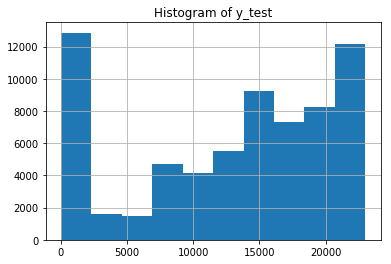

Correlation between y_train and y_test:
 [[1.         0.00753088]
 [0.00753088 1.        ]]
y_test shape after reshaping: (801, 84)
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] estimator__max_depth=2, estimator__n_estimators=80 ..............
[CV] estimator__max_depth=2, estimator__n_estimators=80 ..............
[CV] estimator__max_depth=2, estimator__n_estimators=80 ..............
[CV] estimator__max_depth=2, estimator__n_estimators=100 .............
[CV] estimator__max_depth=2, estimator__n_estimators=100 .............
[CV] estimator__max_depth=2, estimator__n_estimators=100 .............
[CV] estimator__max_depth=3, estimator__n_estimators=80 ..............
[CV] estimator__max_depth=3, estimator__n_estimators=80 ..............
[CV] estimator__max_depth=3, estimator__n_estimators=100 .............
[CV] estimator__max_depth=3, estimator__n_estimators=100 .............
[CV] estimator__max_depth=2, estimator__n_estimators=120 .............
[CV] estimator__max_depth=

[Parallel(n_jobs=-1)]: Done   4 out of  45 | elapsed:   35.2s remaining:  6.0min


[CV]  estimator__max_depth=3, estimator__n_estimators=80, score=-51356780.642278515, total=  40.5s
[CV]  estimator__max_depth=3, estimator__n_estimators=80, score=-51563293.706013285, total=  40.6s
[CV]  estimator__max_depth=3, estimator__n_estimators=80, score=-52218102.11531732, total=  40.6s


[Parallel(n_jobs=-1)]: Done   9 out of  45 | elapsed:   41.0s remaining:  2.7min


[CV]  estimator__max_depth=2, estimator__n_estimators=120, score=-51853461.01202592, total=  41.7s
[CV]  estimator__max_depth=2, estimator__n_estimators=120, score=-52920049.14884929, total=  41.7s
[CV]  estimator__max_depth=2, estimator__n_estimators=120, score=-52083514.97181789, total=  41.8s
[CV]  estimator__max_depth=3, estimator__n_estimators=100, score=-51294281.676211156, total=  50.4s
[CV]  estimator__max_depth=3, estimator__n_estimators=100, score=-52116005.93741109, total=  50.6s
[CV]  estimator__max_depth=3, estimator__n_estimators=100, score=-51445514.591175795, total=  50.6s


[Parallel(n_jobs=-1)]: Done  14 out of  45 | elapsed:   51.0s remaining:  1.9min


[CV]  estimator__max_depth=4, estimator__n_estimators=80, score=-51252292.55260179, total=  53.8s
[CV]  estimator__max_depth=4, estimator__n_estimators=80, score=-52077959.36695816, total=  53.8s
[CV]  estimator__max_depth=4, estimator__n_estimators=80, score=-51384421.613415524, total=  53.9s
[CV]  estimator__max_depth=3, estimator__n_estimators=120, score=-51350195.33770943, total= 1.0min
[CV]  estimator__max_depth=3, estimator__n_estimators=120, score=-52143981.303681836, total= 1.0min


[Parallel(n_jobs=-1)]: Done  19 out of  45 | elapsed:  1.0min remaining:  1.4min


[CV]  estimator__max_depth=3, estimator__n_estimators=120, score=-51417334.68060912, total= 1.0min
[CV]  estimator__max_depth=4, estimator__n_estimators=100, score=-51213060.87257062, total= 1.1min
[CV]  estimator__max_depth=4, estimator__n_estimators=100, score=-51913143.73284413, total= 1.1min
[CV]  estimator__max_depth=4, estimator__n_estimators=100, score=-51337570.00996646, total= 1.1min
[CV]  estimator__max_depth=5, estimator__n_estimators=80, score=-51414795.14600207, total= 1.1min


[Parallel(n_jobs=-1)]: Done  24 out of  45 | elapsed:  1.1min remaining:   59.2s


[CV]  estimator__max_depth=5, estimator__n_estimators=80, score=-52030627.13565556, total= 1.1min
[CV]  estimator__max_depth=5, estimator__n_estimators=80, score=-51381724.48482065, total= 1.1min
[CV]  estimator__max_depth=4, estimator__n_estimators=120, score=-51217486.252338015, total= 1.3min
[CV]  estimator__max_depth=4, estimator__n_estimators=120, score=-51931211.72156761, total= 1.3min
[CV]  estimator__max_depth=4, estimator__n_estimators=120, score=-51244793.98269071, total= 1.3min


[Parallel(n_jobs=-1)]: Done  29 out of  45 | elapsed:  1.3min remaining:   44.7s


[CV]  estimator__max_depth=6, estimator__n_estimators=80, score=-51486921.687746696, total= 1.3min
[CV]  estimator__max_depth=6, estimator__n_estimators=80, score=-52123277.62694101, total= 1.4min
[CV]  estimator__max_depth=6, estimator__n_estimators=80, score=-51427309.372301444, total= 1.4min
[CV]  estimator__max_depth=5, estimator__n_estimators=100, score=-51256487.24632331, total= 1.4min
[CV]  estimator__max_depth=5, estimator__n_estimators=100, score=-51832077.89517255, total= 1.4min


[Parallel(n_jobs=-1)]: Done  34 out of  45 | elapsed:  1.4min remaining:   27.4s


[CV]  estimator__max_depth=5, estimator__n_estimators=100, score=-51366711.45994624, total= 1.4min
[CV]  estimator__max_depth=5, estimator__n_estimators=120, score=-51270060.45312829, total= 1.7min
[CV]  estimator__max_depth=5, estimator__n_estimators=120, score=-51263270.5192192, total= 1.7min
[CV]  estimator__max_depth=6, estimator__n_estimators=100, score=-51413917.71592064, total= 1.7min
[CV]  estimator__max_depth=5, estimator__n_estimators=120, score=-51885793.50826153, total= 1.7min
[CV]  estimator__max_depth=6, estimator__n_estimators=100, score=-51299514.415289864, total= 1.7min


[Parallel(n_jobs=-1)]: Done  39 out of  45 | elapsed:  1.7min remaining:   15.6s


[CV]  estimator__max_depth=6, estimator__n_estimators=100, score=-51946044.70483958, total= 1.7min
[CV]  estimator__max_depth=6, estimator__n_estimators=120, score=-51378646.42742845, total= 2.0min
[CV]  estimator__max_depth=6, estimator__n_estimators=120, score=-51933845.545180775, total= 2.0min
[CV]  estimator__max_depth=6, estimator__n_estimators=120, score=-51287600.3687343, total= 2.0min


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.0min finished


  Best training score: 34121448.27607931
  Best testing score:  51801022.35439034
Best Grid Search model: {'estimator__max_depth': 4, 'estimator__n_estimators': 120}
mean_squared_error: 51801022.35439034


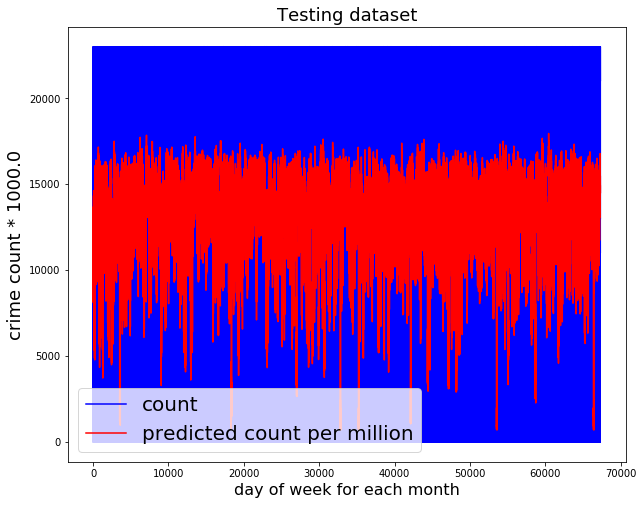

CPU times: user 1min 54s, sys: 10.8 s, total: 2min 5s
Wall time: 4min 21s


In [11]:
%%time

X_train, X_test, y_train, y_test = ready_data(2015, 2017, train_blockid_dict,
                                              X_test_start_year, X_test_end_year, test_blockid_dict,
                                              DAY_OF_WEEK)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
model = MultiOutputRegressor(RandomForestRegressor(max_depth=3, n_estimators=80))
if use_counts == True:
    y_test_dow, y_pred_dow, rpd_dow = get_predictions(X_train, y_train, X_test, y_test, 
                                                      'day of week for each month', 
                                                      f'crime count / population {SEVERITY_OPERATOR} {SEVERITY_SCALING_FACTOR}', 
                                                      model, do_gridsearch=do_gridsearch)
else:
    y_test_dow, y_pred_dow, rpd_dow = get_predictions(X_train, y_train, X_test, y_test, 
                                                      'day of week for each month', 
                                                      f'risk {SEVERITY_OPERATOR} {SEVERITY_SCALING_FACTOR}', 
                                                      model, do_gridsearch=do_gridsearch)

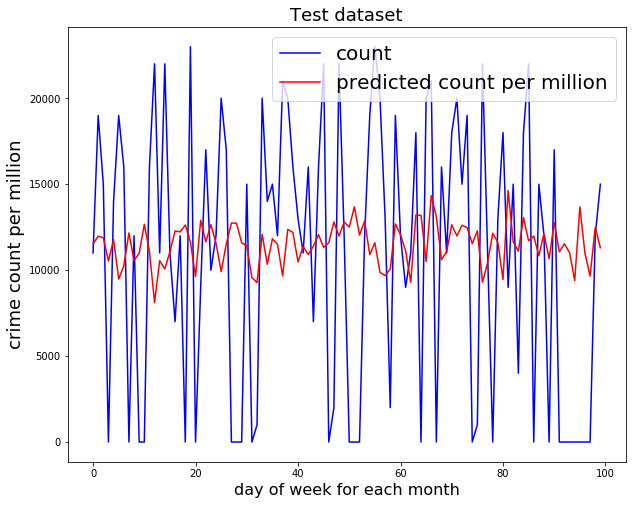

In [12]:
plot_output(y_test.flatten()[:100], y_pred_dow.flatten()[:100], 'Test', 'day of week for each month', 'crime count per million')

## Day of month analysis for each month of each block id

(801, 24, 31) (801, 12, 31) (801, 24, 31) (801, 12, 31)
Number of data points: 297972
Number of non-zero elements: 139058
Percentage of non-zero elements: 0.46668143315479305


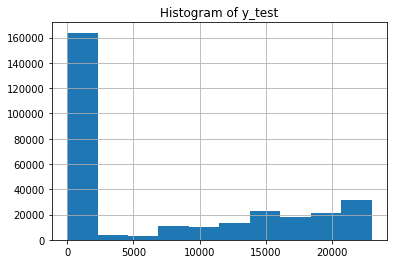

Correlation between y_train and y_test:
 [[1.         0.01869681]
 [0.01869681 1.        ]]
y_test shape after reshaping: (801, 372)
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] estimator__max_depth=2, estimator__n_estimators=80 ..............
[CV] estimator__max_depth=2, estimator__n_estimators=80 ..............
[CV] estimator__max_depth=2, estimator__n_estimators=100 .............
[CV] estimator__max_depth=2, estimator__n_estimators=80 ..............
[CV] estimator__max_depth=2, estimator__n_estimators=100 .............
[CV] estimator__max_depth=2, estimator__n_estimators=100 .............
[CV] estimator__max_depth=2, estimator__n_estimators=120 .............
[CV] estimator__max_depth=2, estimator__n_estimators=120 .............
[CV] estimator__max_depth=2, estimator__n_estimators=120 .............
[CV] estimator__max_depth=3, estimator__n_estimators=80 ..............
[CV] estimator__max_depth=3, estimator__n_estimators=80 ..............
[CV] estimator__max_depth

[Parallel(n_jobs=-1)]: Done   4 out of  45 | elapsed:  7.8min remaining: 80.0min


[CV]  estimator__max_depth=2, estimator__n_estimators=100, score=-62697877.07983159, total= 7.8min
[CV]  estimator__max_depth=2, estimator__n_estimators=100, score=-62321795.67969864, total= 7.8min
[CV]  estimator__max_depth=2, estimator__n_estimators=120, score=-62646161.7513879, total= 9.3min
[CV]  estimator__max_depth=2, estimator__n_estimators=120, score=-63978644.033838645, total= 9.3min
[CV]  estimator__max_depth=2, estimator__n_estimators=120, score=-62289026.29861479, total= 9.4min


[Parallel(n_jobs=-1)]: Done   9 out of  45 | elapsed:  9.4min remaining: 37.7min


[CV]  estimator__max_depth=3, estimator__n_estimators=80, score=-63047457.10882347, total= 9.5min
[CV]  estimator__max_depth=3, estimator__n_estimators=80, score=-61164079.808668084, total= 9.5min
[CV]  estimator__max_depth=3, estimator__n_estimators=80, score=-61106886.1698739, total= 9.5min
[CV]  estimator__max_depth=3, estimator__n_estimators=100, score=-62937927.134792306, total=11.8min
[CV]  estimator__max_depth=3, estimator__n_estimators=100, score=-61160833.4593034, total=11.8min


[Parallel(n_jobs=-1)]: Done  14 out of  45 | elapsed: 11.8min remaining: 26.2min


[CV]  estimator__max_depth=3, estimator__n_estimators=100, score=-61073631.75583409, total=11.8min
[CV]  estimator__max_depth=4, estimator__n_estimators=80, score=-61074413.04042942, total=12.7min
[CV]  estimator__max_depth=4, estimator__n_estimators=80, score=-63028023.93897781, total=12.8min
[CV]  estimator__max_depth=4, estimator__n_estimators=80, score=-61013834.978994936, total=12.8min
[CV]  estimator__max_depth=3, estimator__n_estimators=120, score=-61052274.096315175, total=14.1min


[Parallel(n_jobs=-1)]: Done  19 out of  45 | elapsed: 14.1min remaining: 19.3min


[CV]  estimator__max_depth=3, estimator__n_estimators=120, score=-62939059.19109742, total=14.1min
[CV]  estimator__max_depth=3, estimator__n_estimators=120, score=-61016026.19816952, total=14.2min
[CV]  estimator__max_depth=4, estimator__n_estimators=100, score=-61034675.08676913, total=15.9min
[CV]  estimator__max_depth=4, estimator__n_estimators=100, score=-62882349.71779938, total=15.9min
[CV]  estimator__max_depth=4, estimator__n_estimators=100, score=-60956754.87335737, total=16.0min


[Parallel(n_jobs=-1)]: Done  24 out of  45 | elapsed: 16.1min remaining: 14.0min


[CV]  estimator__max_depth=5, estimator__n_estimators=80, score=-61193607.002777144, total=16.1min
[CV]  estimator__max_depth=5, estimator__n_estimators=80, score=-63131692.067288965, total=16.1min
[CV]  estimator__max_depth=5, estimator__n_estimators=80, score=-61136005.74548875, total=16.2min
[CV]  estimator__max_depth=4, estimator__n_estimators=120, score=-60874517.05652883, total=19.0min
[CV]  estimator__max_depth=4, estimator__n_estimators=120, score=-62860570.26793016, total=19.0min


[Parallel(n_jobs=-1)]: Done  29 out of  45 | elapsed: 19.1min remaining: 10.5min


[CV]  estimator__max_depth=4, estimator__n_estimators=120, score=-60893012.054362945, total=19.1min
[CV]  estimator__max_depth=6, estimator__n_estimators=80, score=-61314962.99580305, total=19.3min
[CV]  estimator__max_depth=6, estimator__n_estimators=80, score=-63159468.67304587, total=19.3min
[CV]  estimator__max_depth=6, estimator__n_estimators=80, score=-61239372.464790285, total=19.4min
[CV]  estimator__max_depth=5, estimator__n_estimators=100, score=-62990704.30995191, total=20.1min


[Parallel(n_jobs=-1)]: Done  34 out of  45 | elapsed: 20.1min remaining:  6.5min


[CV]  estimator__max_depth=5, estimator__n_estimators=100, score=-61122675.21438408, total=20.1min
[CV]  estimator__max_depth=5, estimator__n_estimators=100, score=-61031615.945215724, total=20.2min
[CV]  estimator__max_depth=5, estimator__n_estimators=120, score=-60930571.417099595, total=23.9min
[CV]  estimator__max_depth=5, estimator__n_estimators=120, score=-62961490.058347814, total=24.0min
[CV]  estimator__max_depth=6, estimator__n_estimators=100, score=-61186268.06546796, total=24.0min


[Parallel(n_jobs=-1)]: Done  39 out of  45 | elapsed: 24.0min remaining:  3.7min


[CV]  estimator__max_depth=6, estimator__n_estimators=100, score=-63037524.29138639, total=24.0min
[CV]  estimator__max_depth=5, estimator__n_estimators=120, score=-60972095.22353925, total=24.1min
[CV]  estimator__max_depth=6, estimator__n_estimators=100, score=-61104170.72038534, total=24.3min
[CV]  estimator__max_depth=6, estimator__n_estimators=120, score=-60989741.423123084, total=28.5min
[CV]  estimator__max_depth=6, estimator__n_estimators=120, score=-63022391.41214049, total=28.5min
[CV]  estimator__max_depth=6, estimator__n_estimators=120, score=-61063479.99013437, total=28.5min


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 28.6min finished


  Best training score: 35728157.43678408
  Best testing score:  60804108.92615808
Best Grid Search model: {'estimator__max_depth': 4, 'estimator__n_estimators': 120}
mean_squared_error: 60804108.92615808


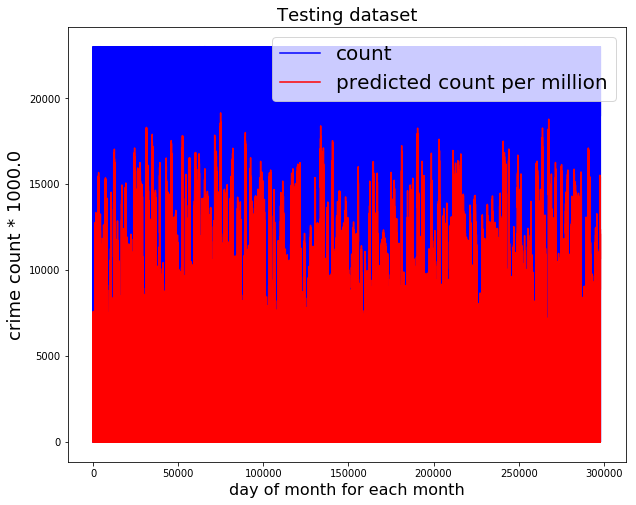

CPU times: user 25min 12s, sys: 11.2 s, total: 25min 23s
Wall time: 54min 15s


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:72: RuntimeWarning: invalid value encountered in true_divide


In [13]:
%%time

X_train, X_test, y_train, y_test = ready_data(2015, 2017, train_blockid_dict,
                                              X_test_start_year, X_test_end_year, test_blockid_dict,
                                              DAY_OF_MONTH)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

model = MultiOutputRegressor(RandomForestRegressor(max_depth=5, n_estimators=120))
if use_counts == True:
    y_test_dom, y_pred_dom, rpd_dom = get_predictions(X_train, y_train, X_test, y_test, 
                                                      'day of month for each month', 
                                                      f'crime count / population {SEVERITY_OPERATOR} {SEVERITY_SCALING_FACTOR}', 
                                                      model, do_gridsearch=do_gridsearch)
else:
    y_test_dom, y_pred_dom, rpd_dom = get_predictions(X_train, y_train, X_test, y_test, 
                                                      'day of month for each month', 
                                                      f'risk {SEVERITY_OPERATOR} {SEVERITY_SCALING_FACTOR}', 
                                                      model, do_gridsearch=do_gridsearch)

## Hour of day analysis for each month of each block id

(801, 24, 24) (801, 12, 24) (801, 24, 24) (801, 12, 24)
Number of data points: 230688
Number of non-zero elements: 119260
Percentage of non-zero elements: 0.5169753086419753


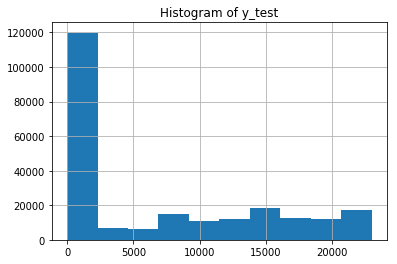

Correlation between y_train and y_test:
 [[1.         0.34015757]
 [0.34015757 1.        ]]
y_test shape after reshaping: (801, 288)
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] estimator__max_depth=2, estimator__n_estimators=80 ..............
[CV] estimator__max_depth=2, estimator__n_estimators=100 .............
[CV] estimator__max_depth=2, estimator__n_estimators=80 ..............
[CV] estimator__max_depth=2, estimator__n_estimators=80 ..............
[CV] estimator__max_depth=2, estimator__n_estimators=100 .............
[CV] estimator__max_depth=2, estimator__n_estimators=100 .............
[CV] estimator__max_depth=2, estimator__n_estimators=120 .............
[CV] estimator__max_depth=2, estimator__n_estimators=120 .............
[CV] estimator__max_depth=2, estimator__n_estimators=120 .............
[CV] estimator__max_depth=3, estimator__n_estimators=80 ..............
[CV] estimator__max_depth=3, estimator__n_estimators=80 ..............
[CV] estimator__max_depth

[Parallel(n_jobs=-1)]: Done   4 out of  45 | elapsed:  1.9min remaining: 19.7min


[CV]  estimator__max_depth=2, estimator__n_estimators=100, score=-35493962.50487239, total= 1.9min
[CV]  estimator__max_depth=2, estimator__n_estimators=100, score=-34142253.10292259, total= 1.9min
[CV]  estimator__max_depth=3, estimator__n_estimators=80, score=-34772355.26264935, total= 2.2min
[CV]  estimator__max_depth=3, estimator__n_estimators=80, score=-34731823.537600674, total= 2.2min
[CV]  estimator__max_depth=3, estimator__n_estimators=80, score=-33219285.686641846, total= 2.2min


[Parallel(n_jobs=-1)]: Done   9 out of  45 | elapsed:  2.2min remaining:  8.9min


[CV]  estimator__max_depth=2, estimator__n_estimators=120, score=-35479124.318751365, total= 2.3min
[CV]  estimator__max_depth=2, estimator__n_estimators=120, score=-35534156.35397908, total= 2.3min
[CV]  estimator__max_depth=2, estimator__n_estimators=120, score=-34105021.45017984, total= 2.3min
[CV]  estimator__max_depth=3, estimator__n_estimators=100, score=-34710334.83407944, total= 2.7min
[CV]  estimator__max_depth=3, estimator__n_estimators=100, score=-34787876.81908161, total= 2.7min


[Parallel(n_jobs=-1)]: Done  14 out of  45 | elapsed:  2.7min remaining:  6.1min


[CV]  estimator__max_depth=3, estimator__n_estimators=100, score=-33247715.65843989, total= 2.7min
[CV]  estimator__max_depth=4, estimator__n_estimators=80, score=-34609307.30035225, total= 2.8min
[CV]  estimator__max_depth=4, estimator__n_estimators=80, score=-34703527.882048644, total= 2.8min
[CV]  estimator__max_depth=4, estimator__n_estimators=80, score=-33128053.31543615, total= 2.9min
[CV]  estimator__max_depth=3, estimator__n_estimators=120, score=-34680678.52215632, total= 3.2min


[Parallel(n_jobs=-1)]: Done  19 out of  45 | elapsed:  3.3min remaining:  4.5min


[CV]  estimator__max_depth=3, estimator__n_estimators=120, score=-34747628.58642817, total= 3.3min
[CV]  estimator__max_depth=3, estimator__n_estimators=120, score=-33217599.141473513, total= 3.3min
[CV]  estimator__max_depth=4, estimator__n_estimators=100, score=-34568389.790785044, total= 3.5min
[CV]  estimator__max_depth=4, estimator__n_estimators=100, score=-34705907.20591046, total= 3.5min
[CV]  estimator__max_depth=4, estimator__n_estimators=100, score=-33078779.482163243, total= 3.6min


[Parallel(n_jobs=-1)]: Done  24 out of  45 | elapsed:  3.6min remaining:  3.1min


[CV]  estimator__max_depth=5, estimator__n_estimators=80, score=-34733708.05059802, total= 3.6min
[CV]  estimator__max_depth=5, estimator__n_estimators=80, score=-33228147.39954624, total= 3.6min
[CV]  estimator__max_depth=5, estimator__n_estimators=80, score=-34782365.172619745, total= 3.6min
[CV]  estimator__max_depth=6, estimator__n_estimators=80, score=-34910238.38379605, total= 4.0min
[CV]  estimator__max_depth=6, estimator__n_estimators=80, score=-34836006.146616064, total= 4.0min


[Parallel(n_jobs=-1)]: Done  29 out of  45 | elapsed:  4.1min remaining:  2.2min


[CV]  estimator__max_depth=6, estimator__n_estimators=80, score=-33324273.549199298, total= 4.1min
[CV]  estimator__max_depth=4, estimator__n_estimators=120, score=-34513059.64415137, total= 4.2min
[CV]  estimator__max_depth=4, estimator__n_estimators=120, score=-34663997.361376256, total= 4.3min
[CV]  estimator__max_depth=4, estimator__n_estimators=120, score=-33075774.48199582, total= 4.3min
[CV]  estimator__max_depth=5, estimator__n_estimators=100, score=-34641072.854234725, total= 4.4min


[Parallel(n_jobs=-1)]: Done  34 out of  45 | elapsed:  4.4min remaining:  1.4min


[CV]  estimator__max_depth=5, estimator__n_estimators=100, score=-34754208.741959445, total= 4.4min
[CV]  estimator__max_depth=5, estimator__n_estimators=100, score=-33151950.64111437, total= 4.5min
[CV]  estimator__max_depth=6, estimator__n_estimators=100, score=-33248089.69252605, total= 5.0min
[CV]  estimator__max_depth=6, estimator__n_estimators=100, score=-34886084.131594524, total= 5.0min
[CV]  estimator__max_depth=6, estimator__n_estimators=100, score=-34764050.96682964, total= 5.0min


[Parallel(n_jobs=-1)]: Done  39 out of  45 | elapsed:  5.1min remaining:   46.9s


[CV]  estimator__max_depth=5, estimator__n_estimators=120, score=-34707875.460021734, total= 5.3min
[CV]  estimator__max_depth=5, estimator__n_estimators=120, score=-34571338.5036656, total= 5.3min
[CV]  estimator__max_depth=5, estimator__n_estimators=120, score=-33139620.369569626, total= 5.3min
[CV]  estimator__max_depth=6, estimator__n_estimators=120, score=-34820828.98596508, total= 5.9min
[CV]  estimator__max_depth=6, estimator__n_estimators=120, score=-34712310.441575885, total= 5.9min
[CV]  estimator__max_depth=6, estimator__n_estimators=120, score=-33208951.741499357, total= 6.0min


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  6.0min finished


  Best training score: 22558108.07150131
  Best testing score:  34110793.26499972
Best Grid Search model: {'estimator__max_depth': 4, 'estimator__n_estimators': 120}
mean_squared_error: 34110793.26499972


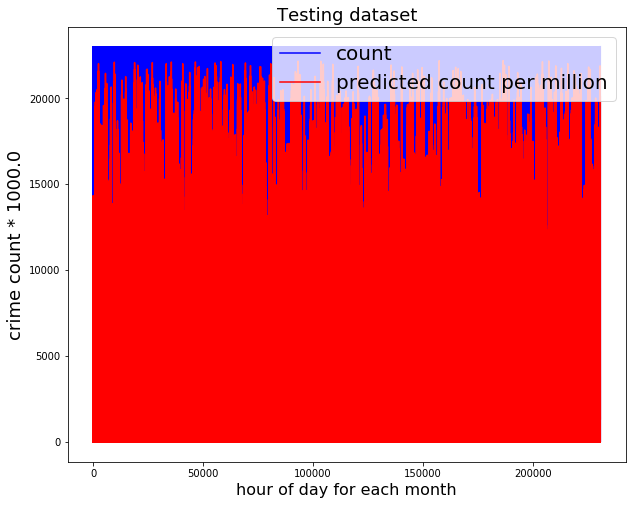

CPU times: user 5min 44s, sys: 7.34 s, total: 5min 52s
Wall time: 12min 15s


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:72: RuntimeWarning: invalid value encountered in true_divide


In [14]:
%%time

X_train, X_test, y_train, y_test = ready_data(2015, 2017, train_blockid_dict,
                                              X_test_start_year, X_test_end_year, test_blockid_dict,
                                              HOUR_OF_DAY)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

model = MultiOutputRegressor(RandomForestRegressor(max_depth=5, n_estimators=100))
if use_counts == True:
    y_test_hod, y_pred_hod, rpd_hod = get_predictions(X_train, y_train, X_test, y_test, 
                                                      'hour of day for each month', 
                                                      f'crime count / population {SEVERITY_OPERATOR} {SEVERITY_SCALING_FACTOR}', 
                                                      model, do_gridsearch=do_gridsearch)
else:
    y_test_hod, y_pred_hod, rpd_hod = get_predictions(X_train, y_train, X_test, y_test, 
                                                      'hour of day for each month', 
                                                      f'risk {SEVERITY_OPERATOR} {SEVERITY_SCALING_FACTOR}', 
                                                      model, do_gridsearch=do_gridsearch)

## Weigh and combine predictions into one array

In [15]:
NUM_BLOCKIDS       = 801
NUM_MONTHS_IN_YEAR = 12
NUM_DAYS_IN_WEEK   = 7
NUM_HOURS_IN_DAY   = 24

risks = np.zeros((NUM_BLOCKIDS, NUM_MONTHS_IN_YEAR, NUM_DAYS_IN_WEEK * NUM_HOURS_IN_DAY))

# Each of the relative percent difference arrays can contain NaN's.
# This is because if both y_pred and y_true were zeros, their
# addition is also zero, and we cannot divide by this zero.
# Here we replace NaN's to get around that issue.
# Since we want to have the highest weight to those values that
# have the same y_pred and y_true, we will give the largest value
# from our array to these NaNs.

def replace_nans(a):
    b = a.copy()
    for row in range(a.shape[0]):
        # max_of_row = np.max(row)
        for col in range(a.shape[1]):
            if np.isnan(a[row][col]):
                # b[row][col] = max_of_row
                b[row][col] = 1.0
    return b

rpd_dow = replace_nans(rpd_dow)
rpd_dom = replace_nans(rpd_dom)
rpd_hod = replace_nans(rpd_hod)

print('Number of nans after replacement:', np.isnan(rpd_dow).sum())

# Returns number of days in a month
def days_in_month(year, month):
    p = pd.Period(f'{year}-{month}-1')
    return p.days_in_month

# Day of week returns 0-based day value
def day_of_week(dt):
    return dt.weekday()

end_year = X_test_end_year

for blockid in range(NUM_BLOCKIDS):
    for month in range(1, NUM_MONTHS_IN_YEAR + 1):
        
        count = np.zeros(NUM_DAYS_IN_WEEK * NUM_HOURS_IN_DAY)
        for day in range(1, days_in_month(end_year, month) + 1):
            for hour in range(24):
                dow  = day_of_week(datetime(end_year, month, day))

                # calculate how good y_pred - y_true is (say for hod) = abs((y_pred_hourly - y_true_hourly) / (y_pred + y_true))
                # 
                # calculate how good y_pred - y_true is (say for hod) = abs((y_pred - y_true) / (y_pred + y_true))
                #                                                      1       8         8           8        8   = 0
                #                                                      0.33   20        4           20       4   = 0.67
                #                                                      0.04   200       4           200      4   = 0.96
                #                                                      
                # calculate relative differences between hod, dow, dom
                #                                                      (pred1 * 1 + pred2 * 0.33)/(1 + 0.33)
                #                                                       0.03*pred1 + 0.24*pred2
                #                                                         (8*1      + 9*0.33)/1.33  = 8.24
                # dow risk = 10    actual = 9   weight = 1  = abs(10 - 9) / (10 + 9) = 0.05
                # dom risk = 8     actual = 8   weight = 2  = abs(8 - 8) / (8 + 8)   = 0
                #                                                 % diff same => same weights
                #                                                 %
                #   (10 * 1 + 8 * 2) / (1 + 2) = 8.6667
                weight_dow = rpd_dow[blockid, (month - 1)*dow]        # risk / #hours => hourly risk
                weight_dom = rpd_dom[blockid, (month - 1)*(day - 1)]  # risk / #hours => hourly risk
                weight_hod = rpd_hod[blockid, (month - 1)*hour]   # (blockid, month, hour)          0, 1, 2, 3 .., 23
                                                                  #    801      12    24     Day  0
                weight_sum = weight_dow + weight_dom + weight_hod #                          Day  1
                                                                  #                                 2, 1.5, 0.2, 0.01
                                                                  #                                 1, 3.5, 
                risks[blockid, month-1, dow * hour] += \
                    (y_pred_dow[blockid, (month - 1)*dow] * weight_dow +
                     y_pred_dom[blockid, (month - 1)*(day - 1)] * weight_dom +
                     y_pred_hod[blockid, (month - 1)*hour] * weight_hod) / weight_sum
                risks[blockid, month-1, dow * hour] += (y_pred_dow[blockid, (month - 1)*dow] +
                                                        y_pred_dom[blockid, (month - 1)*(day - 1)] +
                                                        y_pred_hod[blockid, (month - 1)*hour]) / weight_sum
                
                count[dow * hour] += 1
        risks[blockid, month-1, dow * hour] /= count[dow * hour]
risks_descaled = descale_data(risks)
risks_descaled = np.nan_to_num(risks_descaled)
        

Number of nans after replacement: 0


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:76: RuntimeWarning: invalid value encountered in double_scalars
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:79: RuntimeWarning: divide by zero encountered in double_scalars


In [16]:
def show(a):
    a = pd.Series(risks.flatten())
    print('Number of NaNs:', a.isnull().sum(), 'out of:', len(a))
    a.hist(bins=np.arange(0.0, 3.5, 0.05));

Number of NaNs: 106785 out of: 1614816


0.0        111428
12000.0      6409
18000.0      6220
19000.0      6212
15000.0      6175
17000.0      6120
16000.0      6081
20000.0      6038
21000.0      5944
14000.0      5944
22000.0      5898
13000.0      5723
9000.0       5653
11000.0      5551
10000.0      5523
23000.0      5403
8000.0       5003
1000.0       4465
7000.0       4087
2000.0       3961
3000.0       3588
6000.0       3303
4000.0       3052
5000.0       2907
dtype: int64

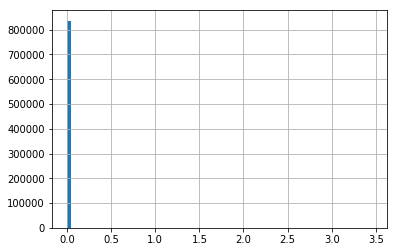

In [17]:
show(y_test)
pd.Series(y_test.flatten()).value_counts()

In [18]:
a = pd.Series(risks.flatten())
a.value_counts(normalize=True)

0.000000      5.545271e-01
11.953478     9.548875e-05
14.941848     2.652465e-05
66.377200     2.387219e-05
49.399556     2.387219e-05
61.846866     2.387219e-05
63.851353     2.387219e-05
34.606290     2.387219e-05
39.309915     2.387219e-05
63.668410     2.387219e-05
72.380415     2.387219e-05
67.727575     2.387219e-05
52.976319     2.387219e-05
42.502997     2.387219e-05
52.419101     2.387219e-05
71.364488     2.387219e-05
74.119523     2.387219e-05
84.915646     2.387219e-05
77.533881     2.387219e-05
41.135818     2.387219e-05
58.914545     2.387219e-05
26.994541     2.387219e-05
60.788633     2.387219e-05
71.521516     2.387219e-05
59.254567     2.387219e-05
72.811201     2.387219e-05
76.230076     2.387219e-05
68.149781     2.387219e-05
54.655354     2.387219e-05
63.066296     2.387219e-05
                  ...     
126.391892    6.631163e-07
144.696479    6.631163e-07
222.099727    6.631163e-07
364.553900    6.631163e-07
234.626646    6.631163e-07
165.731344    6.631163e-07
8

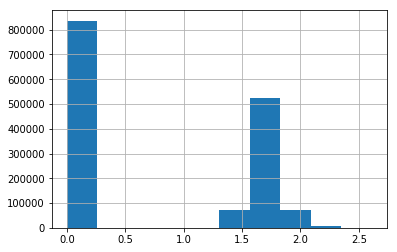

In [19]:
a = pd.Series(risks.flatten()).apply(lambda x: np.power(x, 0.1))
a.hist()  # (bins=np.arange(0.0, 3.5, 0.05));

## Store predictions in DB

In [20]:
from decouple import config

pred_blockid_dict = test_blockid_dict
def store_predictions_in_db(y_pred):
    
    DB_URI_WRITE  = config('DB_URI_WRITE')

    # Put predictions into pandas DataFrame with corresponding block id
    predictions = pd.DataFrame([[x] for x in pred_blockid_dict.keys()], columns=["id"])

    predictions.loc[:, "prediction"] = predictions["id"].apply(lambda x: y_pred[pred_blockid_dict[x],:,:].astype(np.float64).tobytes().hex())
    predictions.loc[:, "month"] = 0
    predictions.loc[:, "year"] = 2018
    predictions.to_csv("predictions.csv", index=False)

    # Query SQL
    query_commit_predictions = """
    CREATE TEMPORARY TABLE temp_predictions (
        id SERIAL PRIMARY KEY,
        prediction TEXT,
        month INTEGER,
        year INTEGER
    );

    COPY temp_predictions (id, prediction, month, year) FROM STDIN DELIMITER ',' CSV HEADER;

    UPDATE block
    SET 
        prediction = DECODE(temp_predictions.prediction, 'hex'),
        month = temp_predictions.month,
        year = temp_predictions.year 
    FROM temp_predictions
    WHERE block.id = temp_predictions.id;

    DROP TABLE temp_predictions;
    """

    # Open saved predictions and send to database using above query
    with open("predictions.csv", "r") as f:
        print("SENDING TO DB")
        RAW_CONN = create_engine(DB_URI_WRITE).raw_connection()
        cursor = RAW_CONN.cursor()
        cursor.copy_expert(query_commit_predictions, f)
        RAW_CONN.commit()
        RAW_CONN.close()

    for r in SESSION.execute("SELECT ENCODE(prediction::BYTEA, 'hex'), id FROM block WHERE prediction IS NOT NULL LIMIT 5;").fetchall():
        print(np.frombuffer(bytes.fromhex(r[0]), dtype=np.float64).reshape((12,7,24)))
        print(y_pred[pred_blockid_dict[int(r[1])], :].reshape((12,7,24)))

In [21]:
with session_scope() as SESSION:
    store_predictions_in_db(risks_descaled)

SENDING TO DB
[[[2562.19405489   87.74637174  175.49274349 ...  157.94346914
    175.49274349   87.74637174]
  [ 298.33766393   70.19709739   87.74637174 ...  140.39419479
     17.54927435    0.        ]
  [ 210.59129218    0.           70.19709739 ...   70.19709739
     70.19709739    0.        ]
  ...
  [  70.19709739    0.            0.         ...    0.
      0.            0.        ]
  [  70.19709739    0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]]

 [[3570.53470525  143.65302459  284.03263631 ...  234.97708294
    252.94699805  200.93395793]
  [ 464.00822425  171.51098122  114.57960769 ...  226.15101558
     48.50828545    0.        ]
  [ 317.19097239    0.          116.1917653  ...  178.70962628
    130.39602324    0.        ]
  ...
  [ 110.21482649    0.            0.         ...    0.
      0.            0.        ]
  [ 121.65074409    0.            0.         ...    0.

In [22]:
def write_predictions_to_db(filename):
    print(f'Writing {filename} to DB')
    with session_scope() as SESSION:
        with open(filename, 'r') as f:
            RAW_CONN = create_engine(DB_URI_WRITE).raw_connection()
            cursor = RAW_CONN.cursor()
            cursor.copy_from(f, temp_predictions, sep=',')
            RAW_CONN.commit()
            RAW_CONN.close()

In [23]:
# If you need to change predictions that were saved to different
# files, use this call:
# write_predictions_to_db('./data/Chicago/predictions_working_week4_sunday_counts_corrected.csv')

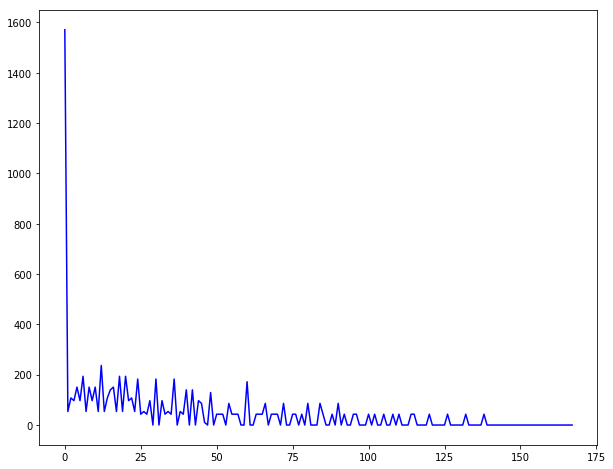

In [24]:
y = risks_descaled[0][0]  # 0th block, January, 168 features (dow * hour).
                          # The largest value is when the dow=0, hour=0
fig = plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(y.flatten())),
             y.flatten(), color='blue');
plt.show()

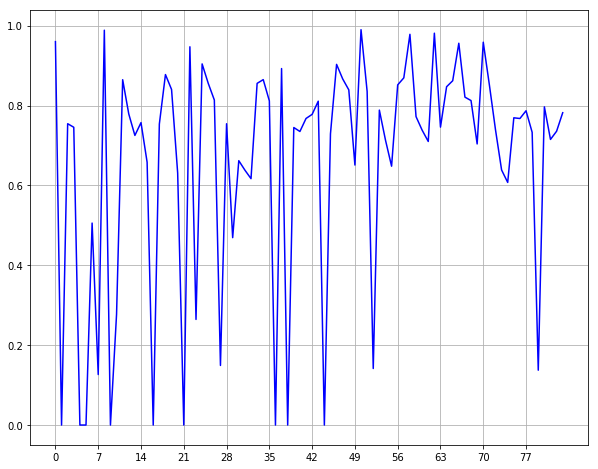

In [25]:
y = rpd_dow[82].flatten()
fig = plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(y.flatten())),
             y.flatten(), color='blue');
plt.xticks(np.arange(0,84,7))
plt.grid(True)
plt.show()

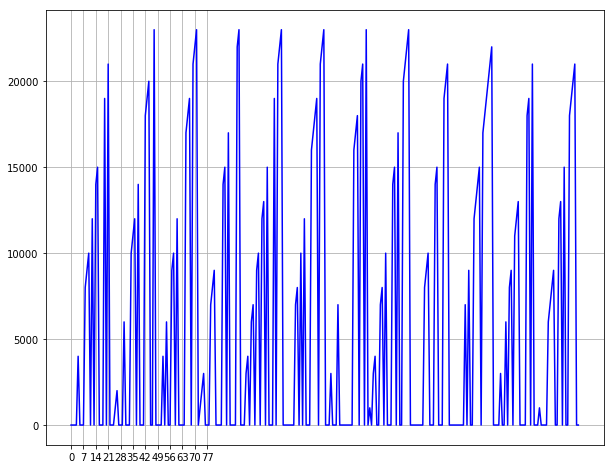

In [26]:
y = y_test[82].flatten()
fig = plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(y.flatten())),
             y.flatten(), color='blue');
plt.xticks(np.arange(0,84,7))
plt.grid(True)
plt.show()

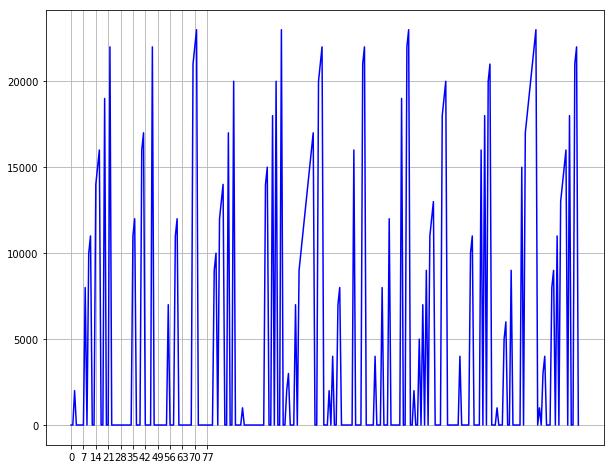

In [27]:
y = y_test[0].flatten()
fig = plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(y.flatten())),
             y.flatten(), color='blue');
plt.xticks(np.arange(0,84,7))
plt.grid(True)
plt.show()

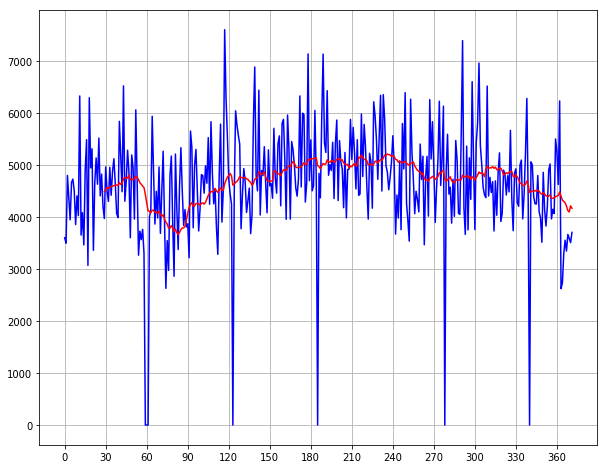

In [28]:
y = y_pred_dom[0].flatten()
df_y = pd.DataFrame(y)
df_y['ma'] = df_y.rolling(window=30).mean()

fig = plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(y.flatten())),
             y.flatten(), color='blue');
plt.plot(np.arange(df_y['ma'].shape[0]),
             df_y['ma'], color='red');
plt.xticks(np.arange(0,372, 30))
plt.grid(True)
plt.show()

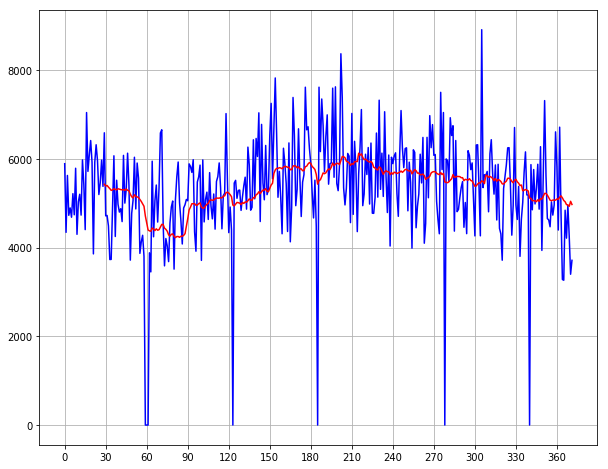

In [29]:
y = y_pred_dom[101].flatten()
df_y = pd.DataFrame(y)
df_y['ma'] = df_y.rolling(window=30).mean()

fig = plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(y.flatten())),
             y.flatten(), color='blue');
plt.plot(np.arange(df_y['ma'].shape[0]),
             df_y['ma'], color='red');
plt.xticks(np.arange(0,372, 30))
plt.grid(True)
plt.show()

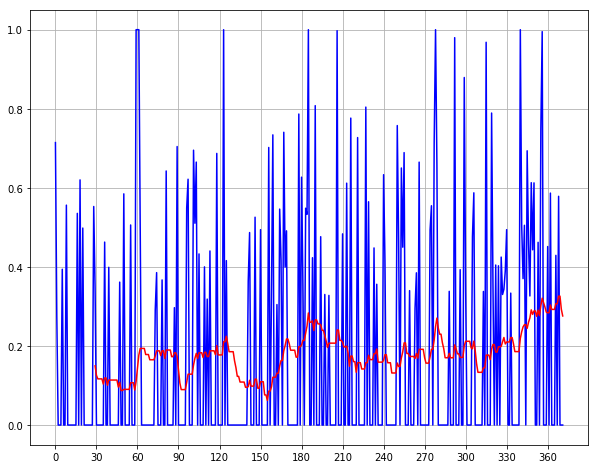

In [30]:
y = rpd_dom[0].flatten()
df_y = pd.DataFrame(y)
df_y['ma'] = df_y.rolling(window=30).mean()

fig = plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(y.flatten())),
             y.flatten(), color='blue');
plt.plot(np.arange(df_y['ma'].shape[0]),
             df_y['ma'], color='red');
plt.xticks(np.arange(0,372, 30))
plt.grid(True)
plt.show()

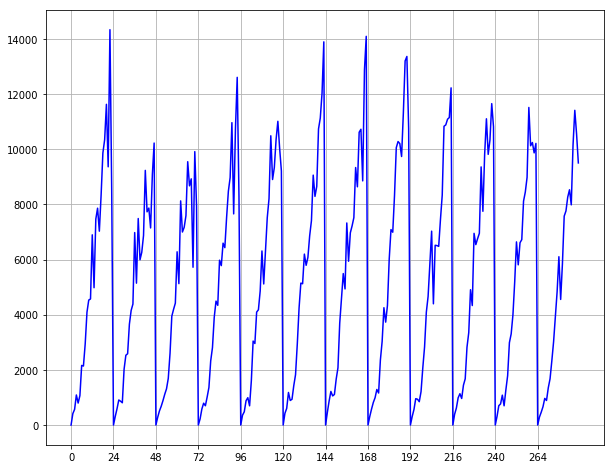

In [31]:
y = y_pred_hod[0].flatten()
fig = plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(y.flatten())),
             y.flatten(), color='blue');
plt.xticks(np.arange(0,288,24))
plt.grid(True)
plt.show()

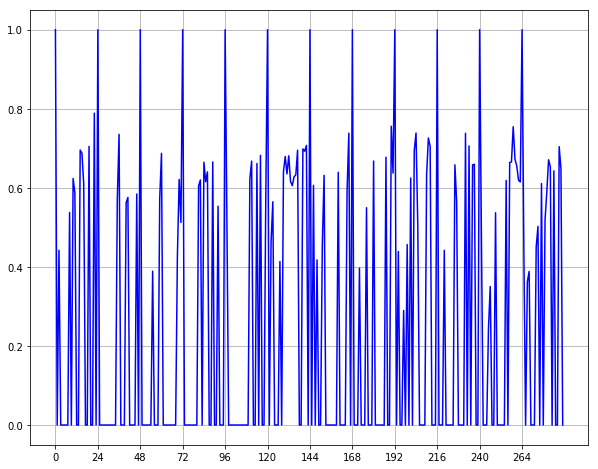

In [32]:
y = rpd_hod[0].flatten()
fig = plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(y.flatten())),
             y.flatten(), color='blue');
plt.xticks(np.arange(0,288,24))
plt.grid(True)
plt.show()

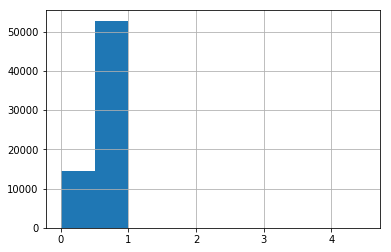

In [33]:
pd.Series(rpd_dow.flatten()).hist(bins=np.arange(0, 5, 0.5))

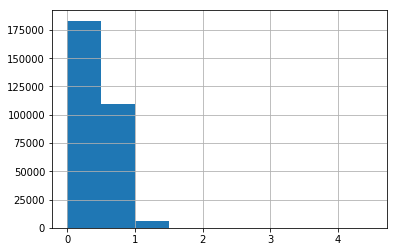

In [34]:
pd.Series(rpd_dom.flatten()).hist(bins=np.arange(0, 5, 0.5))